In [1]:
# remember to load the environment first by running `conda activate colombia_analysis`
#import all the handy dandy libraries
import sys
import numpy as np
import pandas as pd
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import gridspec
%matplotlib inline

#get useful tools from augur
from augur.utils import json_to_tree

#import baltic
import imp
bt = imp.load_source('baltic','./baltic.py')

#datetime libraries
import datetime
from datetime import timedelta

In [2]:
#load tree in as BALTIC tree object
tree = bt.loadJSON(json_object="../gitrepos/ncov/auspice/ncov_humboldt.json",json_translation={'name':'name','absoluteTime':'num_date'},verbose=False,sort=True,stats=True)
print(tree[0])


Tree height: 1.282630
Tree length: 228.339309
multitype tree
annotations present

Numbers of objects in tree: 5046 (2393 nodes and 2653 leaves)



In [3]:
root_date = tree[0].root.traits["num_date"] #decimal date of root.

In [61]:
for k in tree[0].Objects:
    try:
        if k.traits["location"] == "Humboldt County":
            print(k.traits["location_confidence"]["Humboldt County"])
        else:
            continue
    except KeyError:
        continue

0.48053712478419713
1.0
0.9820988740449159
1.0
0.9996736702278843
1.0
0.9999876225988085
1.0
1.0
0.6549373574379611
0.9970860157790777
1.0
1.0
0.5170617170667576
0.9999999999999999
1.0
0.9999999999999999
1.0
0.9828578597105777
1.0
0.9996876105576172
1.0
0.9999876674776809
1.0
0.9999931272959433
1.0
1.0
0.9969095804957612
1.0
0.999953412037426
1.0
1.0
0.9978623216770682
1.0
0.9999694187759381
1.0
0.9999925910194869
0.9999929866287766
0.9999931080671781
0.9999999999999999
0.9999931101985655
1.0
0.9999931121414088
1.0
0.999993222661989
1.0
1.0
0.9999931080671781
0.9999999999999999
0.9999931101985655
1.0
0.9999931121414088
1.0
0.999993222661989
1.0
1.0
0.9999929866287659
0.9999931080671779
1.0
0.9999931101985655
1.0
0.9999931121414088
1.0
0.999993222661989
1.0
1.0
0.999993108066588
1.0
0.9999931101651546
1.0
0.9999931102353717
1.0
0.9999931121420591
1.0
0.9999932226620004
1.0
1.0
0.9824193745081461
1.0
0.999684910676716
1.0
1.0
1.0
1.0
0.999888194741384
0.9999916577617552
1.0
1.0
0.9999998

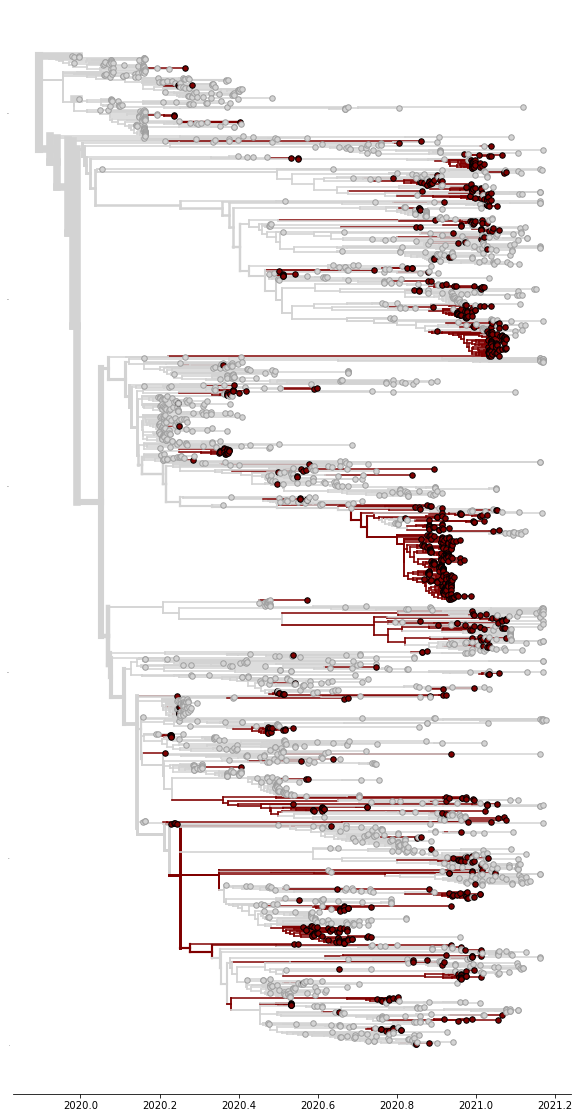

<Figure size 432x288 with 0 Axes>

In [84]:
fig,ax = plt.subplots(figsize=(10,20),facecolor='w')
branchWidth=1.5 ## default branch width
tipSize = 15
s=15

for k in sorted(tree[0].Objects, key=lambda x:x.height):

    try:
        if k.traits["location"] == "Humboldt County" and k.traits["location_confidence"]["Humboldt County"]>0.99:
            color = "maroon"
            edgecolor = "black"
        else:
            color = "#d3d3d3"
            edgecolor = "#a0a0a0"
    except KeyError:
        color = "#d3d3d3"
        edgecolor = "#a0a0a0"
    
    
    if k.branchType=="leaf":
        x = k.traits["num_date"]
        y = k.y
        xp = k.parent.traits["num_date"]
        ax.scatter(x,y,s=30, color=color, edgecolor=edgecolor,zorder=11)#plot tips
        ax.plot([x,xp],[y,y],lw=node_branchwidth,ls='-', color=color)#plot branch leading to tip
        
    elif k.branchType=="node":
        number_children = len(k.leaves)
        node_branchwidth = branchWidth + number_children*0.0025
        y = k.y
        if k.parent.x==None: #this is the root, and matplotlib won't plot Nones. So make x == xp (no branch)
            x= k.traits["num_date"]
            xp = x
        else:
            x = k.traits["num_date"] 
            xp = k.parent.traits["num_date"]
            
        child1_y_value = k.children[-1].y
        child2_y_value = k.children[0].y
        
        ax.plot([x,xp],[y,y],lw=node_branchwidth,ls='-',zorder=9, color=color)#horizontal lines between nodes
        ax.plot([x,x],[child1_y_value,child2_y_value],lw=node_branchwidth,ls='-',zorder=9, color=color) #vertical lines at nodes

#turn off unnecessary axes etc
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y',labelsize=0,size=0)
#ax.set_ylim(-5,tree.ySpan+5)
#ax.set_xlim(2019,2021)



plt.show()
plt.savefig("./full-tree-humboldt-highlight.png", dpi=200)

In [59]:
#step 1: traverse the tree and make subtrees when the country trait changes.
#need a dictionary to hold my subtrees. The way I'm setting this up,
#this dictionary will have key == country where the subtrees circulated 
#value is a list of tuples, each tuple has the "origin country" (aka, from where the introduction came)
#and the second value in the tuple is the baltic tree object for the subtree.
subtrees = []
#also, I need to specify how I want baltic to traverse these subtrees.
#I only want the portion of the subtree that circulated within a deme. 
#Put more simply, I want to see the introduction into a deme, and then only the
#ciruclation within that deme post introduction. 
high_prob_humboldt=lambda w:w.traits["location_confidence"]["Humboldt County"]>0.99 

#okay...actually run the thing now.
for k in sorted(tree[0].Objects, key=lambda x:x.height):
    if k.height == 0:#Exlude the root of the tree, as it has no parent.
        continue
    else:
        try:
            k_location = k.traits["location"]
            k_parent_location = k.parent.traits["location"]
    
            if k_location != k_parent_location and k_location == "Humboldt County": #introduction into Humboldt
                subtree = tree[0].subtree(k)
                if subtree is not None: #there are some weird bits where theres just a branch that isn't Humboldt, and it doesn't get formatted as a tree.
                    subtrees.append((k_parent_location,subtree))
        except KeyError:
            continue

In [93]:
print(len(subtrees))

100


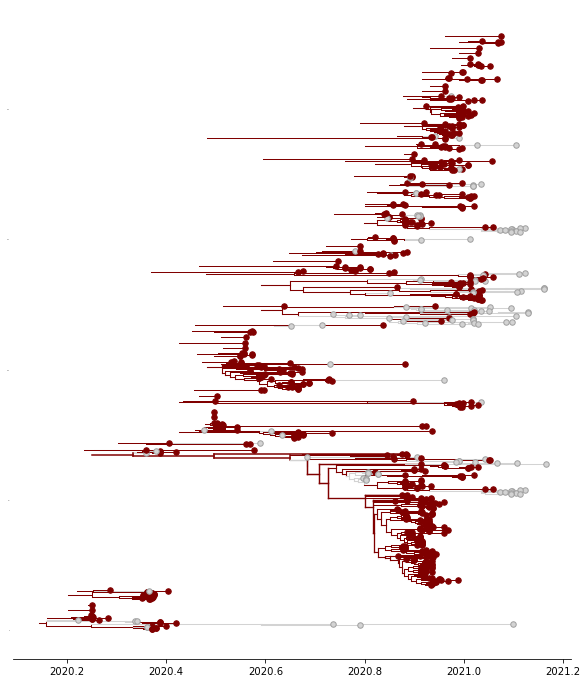

In [118]:
#and now, plot the subtrees
fig,ax = plt.subplots(figsize=(10,12), facecolor="white")

cumulative_y = 0 #need to do a bit of fiddling with y values to make the spacing better on the exploded trees
branchWidth = 1
node_branchwidth = 1

#I want these subtrees sorted by the number of children!
for subtree in subtrees:#sorted(subtrees, key=lambda x: (len(x[1].Objects))): # I want to sort the clades by size
    export_location = subtree[0]
    introduced_clade = subtree[1]
    
    introduced_clade.sortBranches(descending=False) #this is to reassing y values so that clade spacing is better
    
    for k in introduced_clade.Objects:
    
        if k.branchType=="leaf":
            try:
                if k.traits["location"] == "Humboldt County":
                    color = "maroon"
                    edgecolor = "maroon"
                else:
                    color = "#d3d3d3"
                    edgecolor = "#a0a0a0"
            except KeyError:
                color = "#d3d3d3"
                edgecolor = "#a0a0a0"
                
            x = k.traits["num_date"] 
            y = k.y*2 + cumulative_y
            xp = k.parent.traits["num_date"]
            ax.scatter(x,y,s=30, color=color, edgecolor = edgecolor, zorder=11)#plot tips
            ax.plot([x,xp],[y,y],lw=node_branchwidth, ls='-', color=color)#plot branch leading to tip
        
        elif k.branchType=="node":
            try:
                if k.traits["location"] == "Humboldt County":
                    color = "maroon"
                else:
                    color = "#d3d3d3"
            except KeyError:
                color = "#d3d3d3"
            
            number_children = len(k.leaves)
            node_branchwidth = branchWidth + number_children*0.002
            y = k.y*2 + cumulative_y
            if k.parent.x==None: #this is the root, and matplotlib won't plot Nones. So make x == xp (no branch)
                x=k.traits["num_date"]
                xp = x
            else:
                x = k.traits["num_date"]
                xp = k.parent.traits["num_date"]
            
            child1_y_value = k.children[-1].y*2 + cumulative_y
            child2_y_value = k.children[0].y*2 + cumulative_y

            ax.plot([x,xp],[y,y],lw=node_branchwidth, ls='-',zorder=9, color=color)#horizontal lines between nodes
            ax.plot([x,x],[child1_y_value,child2_y_value],lw=node_branchwidth, ls='-',zorder=9, color=color) #vertical lines at nodes
   
    #customize spacing between the clades a bit.
    #print(introduced_clade.ySpan)
    if introduced_clade.ySpan <= 1:
        cumulative_y += 20
    else:
        cumulative_y += introduced_clade.ySpan*2
    
    
#turn off unnecessary axes etc
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y',labelsize=0,size=0)
#ax.set_xlim(2014.5,2017)

plt.savefig("./exploded-tree-lineages", dpi=200)

In [97]:
clades = {}

clade_number = 0

for subtree in subtrees:
    clades["intro_clade_{}".format(clade_number)] = {}
    seq_names = []
    n_leaves = 0
    for k in subtree[1].Objects:
        try:
            if k.branchType == "leaf" and k.traits["location"]=="Humboldt County":
                n_leaves += 1
                seq_names.append(k.traits["name"])
            elif k.branchType == "node":
                continue
        except KeyError:
            continue
    clades["intro_clade_{}".format(clade_number)]["sequence_names"] = seq_names
    clades["intro_clade_{}".format(clade_number)]["n_humboldt_leaves"] = n_leaves
    clade_number += 1



{'intro_clade_0': {'sequence_names': ['USA/CA-CZB-2429/2020', 'USA/CA-CZB-2430/2020', 'USA/CA-CZB-2436/2020', 'USA/CA-CZB-2431/2020', 'USA/CA-CZB-2443/2020', 'USA/CA-CZB-2419/2020', 'USA/CA-CZB-2426/2020', 'USA/CA-CZB-2425/2020', 'USA/CA-CZB-2420/2020', 'USA/CA-CZB-2042/2020'], 'n_humboldt_leaves': 10}, 'intro_clade_1': {'sequence_names': ['USA/CA-CZB-1512/2020'], 'n_humboldt_leaves': 1}, 'intro_clade_2': {'sequence_names': ['USA/CA-CZB-1513/2020', 'USA/CA-CZB-1280/2020', 'USA/CA-CZB-1281/2020', 'USA/CA-CZB-1508/2020'], 'n_humboldt_leaves': 4}, 'intro_clade_3': {'sequence_names': ['USA/CA-CZB-1283/2020', 'USA/CA-CZB-1509/2020'], 'n_humboldt_leaves': 2}, 'intro_clade_4': {'sequence_names': ['USA/CA-CZB-1506/2020', 'USA/CA-CZB-1511/2020'], 'n_humboldt_leaves': 2}, 'intro_clade_5': {'sequence_names': ['USA/CA-CZB-1510/2020'], 'n_humboldt_leaves': 1}, 'intro_clade_6': {'sequence_names': ['USA/CA-CZB-1282/2020'], 'n_humboldt_leaves': 1}, 'intro_clade_7': {'sequence_names': ['USA/CA-CZB-1507

In [107]:
#write our tsv file with clade sizes for Joe
n_clades_with_more_than_ten = 0

with open("./introduction_sizes.tsv", "w") as file:
    file.write(str("clade" + "\t" + "n_humboldt_samples_in_clade" + "\n"))
    for key in clades.keys():
        string = str(key) + "\t" + str(clades[key]["n_humboldt_leaves"]) + "\n"
        file.write(string)
        if clades[key]["n_humboldt_leaves"]>10:
            n_clades_with_more_than_ten += 1
            
print(n_clades_with_more_than_ten)
            

11


In [117]:
#need to grab the genomes for joe for the samples in clades with >10 descendents.
from Bio import SeqIO
humboldt_build_sequences = SeqIO.to_dict(SeqIO.parse("../gitrepos/ncov/results/humboldt/aligned.fasta", "fasta"))
#print(humboldt_build_sequences["USA/CA-CDPH-UC3/2020"].seq)

for key in clades.keys():
    if clades[key]["n_humboldt_leaves"]>10:
        strains = clades[key]["sequence_names"]
        with open("./{}.fasta".format(key),"w") as file:
            for strain in strains:
                file.write(">" + str(strain) + "\n" + str(humboldt_build_sequences[strain].seq) + "\n")  
    else:
        continue


0
